##### Imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from ta import momentum
from ta import volume
from ta import volatility
from ta import trend


##### Miscellaneous

In [54]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data acquisition method

##### Load from file (obtained through data extraction tool)

In [55]:
def get_stock_data_and_period_csv(filepath: str):
    df = pd.read_csv(filepath)

    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]

    print('Time Period: ' + str(start_date) + ' to ' + str(end_date))

    return df, start_date, end_date

# Data Transform

In [56]:
def dataframe_copy(df: pd.DataFrame):
    df_copy = df.copy()
    return df_copy

In [57]:
def dataframe_clean(df: pd.DataFrame):
    clean_df = df.dropna()
    clean_df = clean_df.drop(['Date'], axis=1)  # we remove 'Date' here so the original data is untouched.
    return clean_df

In [58]:
def dataframe_stats(df: pd.DataFrame):
    print(df.shape)
    print(df.columns)
    print(df.isnull().sum())

##### Preparing data for loading into model

In [59]:
def set_column_as_first(df: pd.DataFrame, col_name: str):
    col_loc = df.columns.get_loc(col_name)
    if col_loc != 0:
        cols = list(df.columns)
        a, b = cols.index(col_name), cols.index(df.columns[0])
        cols[b], cols[a] = cols[a], cols[b]
        df = df[cols]
    
    return df

In [60]:
# used for plotting purposes
def scaler_fit_column(df: pd.DataFrame, target: str = 'Close'):
    scaler = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
    scaler.fit(df[[target]])

    return scaler

In [61]:
def transform_data(df: pd.DataFrame):
    # Scale the data
    cols = df.columns

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)    # fit and transform for all data
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = cols

    return df_scaled

In [62]:
# by default, the target is the 'Close' price of the stock
def get_features_and_target(df: pd.DataFrame, target: str = 'Close'):
    df_features = df
    df_target = df[[target]]

    return df_features, df_target

##### Train Data Setup

In [63]:
def setup_train_data(features: pd.DataFrame, target: pd.DataFrame, train_data_percent: float = 0.8):
    train_data_len = math.ceil(len(features.to_numpy()) * train_data_percent)

    train_x = features[0:train_data_len].to_numpy()
    train_y = target[0:train_data_len].to_numpy()

    return train_x, train_y, train_data_len


In [64]:
def prepare_train_as_sliding_window(train_x, train_y, sliding_window_size: int = 5):
    x_train_sw = []
    y_train_sw = []

    # The sliding window size (in days) we use as input. There are 5 trading days in a week
    for i in range(sliding_window_size, len(train_x)):
        x_train_sw.append(train_x[i-sliding_window_size:i,:])
        y_train_sw.append(train_y[i:i+1, 0])

    x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

    return x_train_sw, y_train_sw

In [65]:
##### REMOVE THIS?

def setup_test_data(features, target, train_data_len):
    test_x = features[train_data_len:].to_numpy()
    test_y = target[train_data_len:].to_numpy()

    return test_x, test_y

In [66]:
##### REMOVE THIS?

def prepare_test_as_sliding_window(test_x, test_y, sliding_window_size: int = 5):
    x_test_sw = []  # features
    y_test_sw = []  # target
    y_remaining = []    # features remaining

    for i in range(sliding_window_size, len(test_x)):
        x_test_sw.append(test_x[i-sliding_window_size:i,:])
        y_test_sw.append(test_y[i:i+1,0])
        y_remaining.append(test_x[i:i+1,1:])

    x_test_sw = np.array(x_test_sw)
    y_test_sw = np.array(y_test_sw)
    y_remaining = np.array(y_remaining)

    return x_test_sw, y_test_sw, y_remaining

In [67]:
# unused b/c idk
def forecast(model: Model, x_train_sw):
    x_train_sw.shape

    test_input = np.reshape(x_train_sw[-1], (1, x_train_sw.shape[1], x_train_sw.shape[2]))  # use the last sliding window as input.
    test_input.shape

    prediction_values = model.predict(test_input)   # from one prediction, we get several values
    pred_vals = np.array(prediction_values) # convert to numpy array
    pred_vals.shape

# Transformer Model

In [68]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [69]:
def build_model(    
    x_train_sw,
    sliding_window_size: int = 5,
    head_size=128,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=8,
    mlp_units=128,
    mlp_dropout=0.05,
    dropout=0.05,
):
    input_shape = x_train_sw.shape[1:]
    input_shape = (sliding_window_size, input_shape[1])
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    mlp_units_array = [mlp_units]
    for dim in mlp_units_array:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(10)(x)
    return Model(inputs, outputs)

##### Model Callbacks

In [70]:
# you can add new callbacks by adding them here
def get_model_callbacks():
    # Adding EarlyStopping callback (for lots of epochs)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    # Adding ModelCheckpoint callback
    # Define the path to save the best weights. The best weights will be used for stock prediction.
    checkpoint_path = 'best_weights.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

    model_callbacks = [early_stopping, checkpoint]

    return model_callbacks

##### Model Creation and Training

In [71]:
def compile_model(model: Model, metrics=['mse', 'mae', 'mape'], learning_rate=0.0001):
    model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=metrics
    )

    return model

# General guidelines for hyperparameters
# - head_size and mlp_units should be large values (i.e. 256 for head_size and mlp_units, 8 num_heads, ff_dim, num_transformer_blocks)
# - you can't just keep increasing the hyperparameter values, memory is your constraint.

##### Model Fitting

In [72]:
# train the model in a function here.
def train_model(model: Model, model_callbacks, x_train, y_train, train_validation_split: float = 0.8, epochs: int = 20, batch_size: int = 128):  
    # A higher train_validation_split value will mean more data is used for training, less for validation.
    history = model.fit(
                x_train,
                y_train,
                validation_split=1-train_validation_split,  # lil bug was hiding here
                epochs=epochs,
                batch_size=batch_size,
                callbacks=model_callbacks
            )

    # Load the best weights into the model
    model.load_weights('best_weights.h5')

    return model, history

##### Model Evaluation

In [73]:
def evaluate_model(model: Model, x_test_sw, y_test_sw):
    model.evaluate(x_test_sw, y_test_sw, verbose=1)

##### Performing Prediction Steps

In [74]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_ground_truth(model: Model, input_data, remaining_y):

    # reshape the input to (1, sliding_window_size, features)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    last_gt_price = np.reshape(input_data[0][0], (1, 1))

    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_gt_price, remaining_y), axis=1)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    # shifting the sliding window one step forward
    test_x = test_x[1:]

    return test_x, prediction_value

In [75]:
# This function performs a single step prediction without adding feature values. 
def perform_prediction_step_tomorrow(model: Model, input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [76]:
def perform_model_predictions(model, test_x, y_remaining):
    prediction_values = []
    new_test_x = test_x[0].copy()

    # Repeated single step prediction with the available data
    for i in range(y_remaining.shape[0]):
        new_test_x, prediction = perform_prediction_step_on_ground_truth(model, new_test_x, y_remaining[i])
        prediction_values.append(prediction)

    # Single step prediction into the future!
    prediction = perform_prediction_step_tomorrow(model, new_test_x)
    prediction_values.append(prediction)

    pred_vals = np.array(prediction_values)
    pred_vals = pred_vals.squeeze(1)

    return pred_vals

##### RMSE

In [77]:
def calculate_rmse(actual_values, predicted_values):
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    return rmse

# Graphs Output

#### Prediction vs Ground Truth Graph

In [78]:
def plot_prediction_vs_gt(scaler: MinMaxScaler, predicted, ground_truth, start_date, end_date, train_data_len, train_validation_split):
    # Use the unscaled data to see prices
    scaler_predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    scaler_ground_truth = scaler.inverse_transform(ground_truth)

    plt.figure(figsize=(15, 6))

    # Adding the predicted, ground truth, and tomorrow's prediction
    plt.plot(scaler_predicted.flatten(), label='Predictions', color='#0000FF')
    plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#00FF00')

    # Adding vertical lines indicating different data usages
    plt.axvline(x=0, label='Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
    plt.axvline(x=train_data_len * train_validation_split, label='Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
    plt.axvline(x=train_data_len, label='Predictions Start', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,0,2,3,4]

    plt.xlabel('Date (' + start_date + ' to ' + end_date + ') + 1')
    plt.ylabel('Stock Price ($)')
    plt.title('Prediction vs Ground Truth')
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig('Prediction.png')
    plt.show()


#### Daily Closing Prices

In [79]:
def plot_daily_close(df: pd.DataFrame, ticker: str):
    # Plotting daily closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Closing Price')
    plt.title(ticker + ' Daily Closing Prices')
    plt.show()

#### Daily Stock Returns

In [80]:
def plot_daily_returns(df: pd.DataFrame, ticker: str):
    df['Daily_Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)

    plt.figure(figsize=(12, 6))

    # Plotting daily stock returns
    plt.plot(df['Date'][1:], df['Daily_Return'][1:], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Daily Return')
    plt.title(ticker + ' Daily Stock Return')
    plt.show()

#### Loss from Training and Validation

In [81]:
def plot_loss_chart(history):
    # Accessing training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Generating a list of epochs (x-axis)
    epochs = range(1, len(training_loss) + 1)


    plt.figure(figsize=(8, 4))

    # Plotting the training and validation loss over iterations
    plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
    plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# The entire program

In [82]:
ticker = 'AMZN'
filepath = 'ta_stock_data_' + ticker + '.csv'   # use 'ta_stock_data_TICKER.csv' for technical analysis, or 'ps_stock_data_TICKER.csv' for parallel stock.
target_col = 'Close'

df, start_date, end_date = get_stock_data_and_period_csv(filepath)

df

Time Period: 2013-11-05 to 2023-09-22


,Date,Open,High,Low,Close,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,2013-11-05,17.839001,18.008499,17.742001,17.944500,40142000,68.610665,1.647633,1.739838e+07,-0.006473,0.024615,18.996664,17.724800,16.452937,0.437056,0.557407,0.491387,80.0,85.0,5.0
1,2013-11-06,18.022499,18.143499,17.725000,17.809000,45646000,64.658934,1.541308,1.311049e+07,0.054093,0.041932,18.746333,17.871900,16.997468,0.435200,0.519610,0.497032,75.0,80.0,5.0
2,2013-11-07,17.792999,17.895000,17.094000,17.177999,84926000,49.813551,1.359250,9.834285e+05,-0.414761,-0.001812,18.483536,17.928650,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0
3,2013-11-08,17.297501,17.552500,17.202000,17.515499,53138000,55.839164,1.171575,4.065361e+06,-0.077339,-0.060035,18.442787,17.863250,17.283713,0.462052,0.381996,0.462980,60.0,70.0,10.0
4,2013-11-11,17.529499,17.768499,17.403000,17.719000,45234000,59.126939,1.047508,4.999868e+06,0.168472,-0.042167,18.429121,17.844350,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,2023-09-18,140.479996,141.750000,139.220001,139.979996,42823500,53.326815,4.824500,-2.998813e+07,-7.946224,2.523699,146.394761,140.298001,134.201241,3.311380,1.699447,1.468130,65.0,85.0,20.0
2483,2023-09-19,138.699997,138.839996,135.559998,137.630005,61482500,46.902409,4.021665,-5.080544e+07,-17.525000,1.555661,146.362689,140.334001,134.305313,3.422242,1.298400,1.434184,65.0,80.0,15.0
2484,2023-09-20,138.550003,139.369995,135.199997,135.289993,46263700,41.386072,2.971832,-6.125129e+07,0.766143,2.162415,146.378894,140.327000,134.275107,3.497018,0.776438,1.302635,65.0,75.0,10.0
2485,2023-09-21,131.940002,132.240005,129.309998,129.330002,70234800,31.050948,0.510333,-1.262236e+08,-27.157955,-0.116580,148.399191,139.475000,130.550809,3.745315,-0.139410,1.014226,-30.0,70.0,100.0


In [83]:
df_copy = dataframe_copy(df)
df = dataframe_clean(df)
dataframe_stats(df)

df

(2487, 19)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'awesome_oscillator',
       'force_index', 'ease_of_movement', 'ease_of_movement_signal',
       'bbands_upper', 'bbands_middle', 'bbands_lower', 'atr', 'macd',
       'macd_signal', 'aroon', 'aroon_up', 'aroon_down'],
      dtype='object')
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
rsi                        0
awesome_oscillator         0
force_index                0
ease_of_movement           0
ease_of_movement_signal    0
bbands_upper               0
bbands_middle              0
bbands_lower               0
atr                        0
macd                       0
macd_signal                0
aroon                      0
aroon_up                   0
aroon_down                 0
dtype: int64


,Open,High,Low,Close,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,17.839001,18.008499,17.742001,17.944500,40142000,68.610665,1.647633,1.739838e+07,-0.006473,0.024615,18.996664,17.724800,16.452937,0.437056,0.557407,0.491387,80.0,85.0,5.0
1,18.022499,18.143499,17.725000,17.809000,45646000,64.658934,1.541308,1.311049e+07,0.054093,0.041932,18.746333,17.871900,16.997468,0.435200,0.519610,0.497032,75.0,80.0,5.0
2,17.792999,17.895000,17.094000,17.177999,84926000,49.813551,1.359250,9.834285e+05,-0.414761,-0.001812,18.483536,17.928650,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0
3,17.297501,17.552500,17.202000,17.515499,53138000,55.839164,1.171575,4.065361e+06,-0.077339,-0.060035,18.442787,17.863250,17.283713,0.462052,0.381996,0.462980,60.0,70.0,10.0
4,17.529499,17.768499,17.403000,17.719000,45234000,59.126939,1.047508,4.999868e+06,0.168472,-0.042167,18.429121,17.844350,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,140.479996,141.750000,139.220001,139.979996,42823500,53.326815,4.824500,-2.998813e+07,-7.946224,2.523699,146.394761,140.298001,134.201241,3.311380,1.699447,1.468130,65.0,85.0,20.0
2483,138.699997,138.839996,135.559998,137.630005,61482500,46.902409,4.021665,-5.080544e+07,-17.525000,1.555661,146.362689,140.334001,134.305313,3.422242,1.298400,1.434184,65.0,80.0,15.0
2484,138.550003,139.369995,135.199997,135.289993,46263700,41.386072,2.971832,-6.125129e+07,0.766143,2.162415,146.378894,140.327000,134.275107,3.497018,0.776438,1.302635,65.0,75.0,10.0
2485,131.940002,132.240005,129.309998,129.330002,70234800,31.050948,0.510333,-1.262236e+08,-27.157955,-0.116580,148.399191,139.475000,130.550809,3.745315,-0.139410,1.014226,-30.0,70.0,100.0


In [84]:
df = set_column_as_first(df, col_name=target_col)

df

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,17.944500,18.008499,17.742001,17.839001,40142000,68.610665,1.647633,1.739838e+07,-0.006473,0.024615,18.996664,17.724800,16.452937,0.437056,0.557407,0.491387,80.0,85.0,5.0
1,17.809000,18.143499,17.725000,18.022499,45646000,64.658934,1.541308,1.311049e+07,0.054093,0.041932,18.746333,17.871900,16.997468,0.435200,0.519610,0.497032,75.0,80.0,5.0
2,17.177999,17.895000,17.094000,17.792999,84926000,49.813551,1.359250,9.834285e+05,-0.414761,-0.001812,18.483536,17.928650,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0
3,17.515499,17.552500,17.202000,17.297501,53138000,55.839164,1.171575,4.065361e+06,-0.077339,-0.060035,18.442787,17.863250,17.283713,0.462052,0.381996,0.462980,60.0,70.0,10.0
4,17.719000,17.768499,17.403000,17.529499,45234000,59.126939,1.047508,4.999868e+06,0.168472,-0.042167,18.429121,17.844350,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,139.979996,141.750000,139.220001,140.479996,42823500,53.326815,4.824500,-2.998813e+07,-7.946224,2.523699,146.394761,140.298001,134.201241,3.311380,1.699447,1.468130,65.0,85.0,20.0
2483,137.630005,138.839996,135.559998,138.699997,61482500,46.902409,4.021665,-5.080544e+07,-17.525000,1.555661,146.362689,140.334001,134.305313,3.422242,1.298400,1.434184,65.0,80.0,15.0
2484,135.289993,139.369995,135.199997,138.550003,46263700,41.386072,2.971832,-6.125129e+07,0.766143,2.162415,146.378894,140.327000,134.275107,3.497018,0.776438,1.302635,65.0,75.0,10.0
2485,129.330002,132.240005,129.309998,131.940002,70234800,31.050948,0.510333,-1.262236e+08,-27.157955,-0.116580,148.399191,139.475000,130.550809,3.745315,-0.139410,1.014226,-30.0,70.0,100.0


In [85]:
scaler = scaler_fit_column(df, target=target_col)
df = transform_data(df)

df

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020886,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577922,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020099,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.016435,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.018395,0.017409,0.017593,0.017791,0.077285,0.521187,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.019576,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.729476,0.730643,0.732656,0.729911,0.054837,0.488189,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.715831,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337093,0.620360,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.702244,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.667637,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255846,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [86]:
features, target = get_features_and_target(df, target=target_col)

print(features.shape)
print(target.shape)

train_data_percent = 1.0
train_validation_split = 0.9
sliding_window_size = 5
tolerance_percent = 2

(2487, 19)
(2487, 1)


In [87]:
features

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020886,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577922,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020099,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.016435,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.018395,0.017409,0.017593,0.017791,0.077285,0.521187,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.019576,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.729476,0.730643,0.732656,0.729911,0.054837,0.488189,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.715831,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337093,0.620360,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.702244,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.667637,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255846,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [88]:
target

,Close
0,0.020886
1,0.020099
2,0.016435
3,0.018395
4,0.019576
...,...
2482,0.729476
2483,0.715831
2484,0.702244
2485,0.667637


In [89]:
train_x, train_y, train_data_len = setup_train_data(features, target, train_data_percent)
x_train_sw, y_train_sw = prepare_train_as_sliding_window(train_x, train_y, sliding_window_size)

print(train_x.shape)
print(train_y.shape)
print(x_train_sw.shape)
print(y_train_sw.shape)

(2487, 19)
(2487, 1)
(2482, 5, 19)
(2482, 1)


In [90]:
model = build_model(
    x_train_sw, 
    sliding_window_size,
    head_size=128,
    num_heads=8, 
    ff_dim=8, 
    num_transformer_blocks=8, 
    mlp_units=128, 
    mlp_dropout=0.05, 
    dropout=0.05
    )
model = compile_model(model, learning_rate=0.001)

In [91]:
model, history = train_model(model, get_model_callbacks(), x_train_sw, y_train_sw, train_validation_split, epochs=20, batch_size=128)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.0599 - mse: 0.0599 - mae: 0.1621 - mape: 50014.0625
Epoch 1: val_loss improved from inf to 0.00448, saving model to best_weights.h5
18/18 [==============================] - 9s 150ms/step - loss: 0.0599 - mse: 0.0599 - mae: 0.1621 - mape: 50014.0625 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0515 - val_mape: 9.7004
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.0106 - mse: 0.0106 - mae: 0.0750 - mape: 16908.9141
Epoch 2: val_loss improved from 0.00448 to 0.00321, saving model to best_weights.h5
18/18 [==============================] - 2s 102ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0750 - mape: 16908.9141 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0448 - val_mape: 8.1671
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0066 - mae: 0.0589 - mape: 18746.6484
Epoch 3: val_loss improved from 0.00321 to 0.00121, saving model to best_weights.h5
18/1

In [92]:
test_input = np.reshape(x_train_sw[-1], (1, x_train_sw.shape[1], x_train_sw.shape[2]))  # use the last sliding window as input.
prediction_values = model.predict(test_input)   # from one prediction, we get several values
pred_vals = np.array(prediction_values) # convert to numpy array

1/1 [==============================] - 1s 687ms/step


In [93]:
ground_truth_x_axis = df['Close'].values.reshape(-1, 1)
predicted_x_axis = np.append(ground_truth_x_axis, pred_vals)

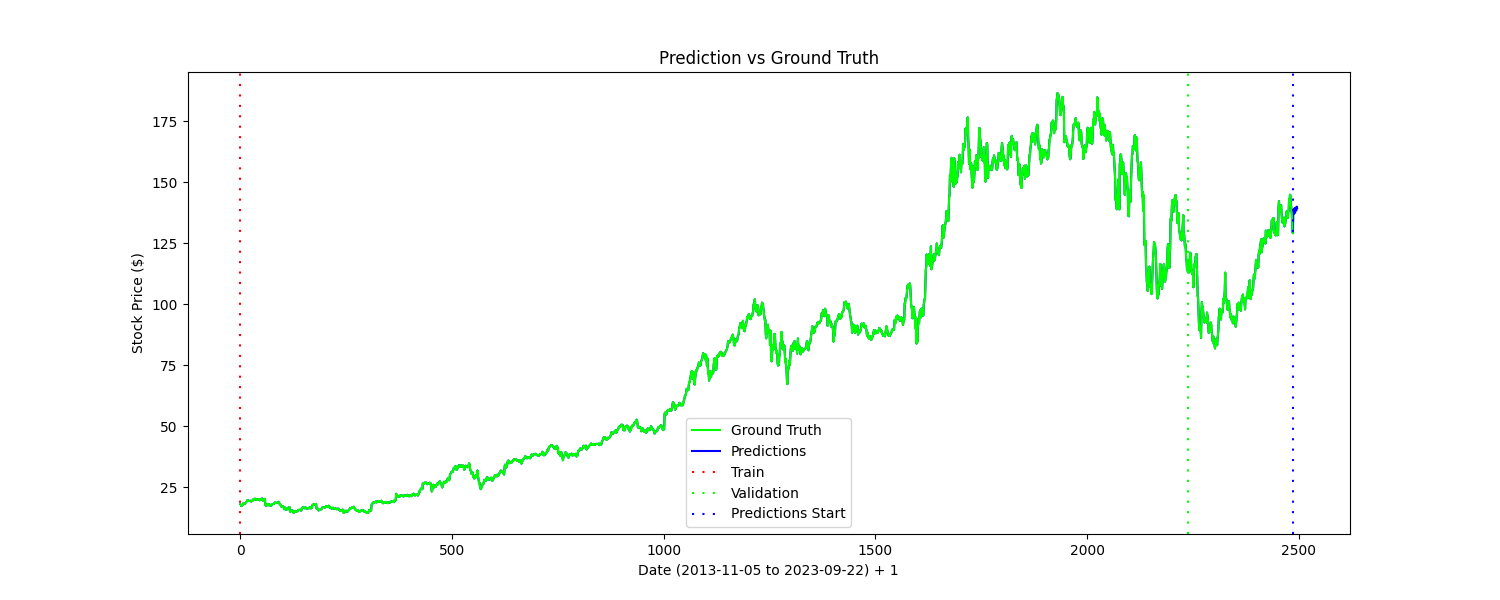

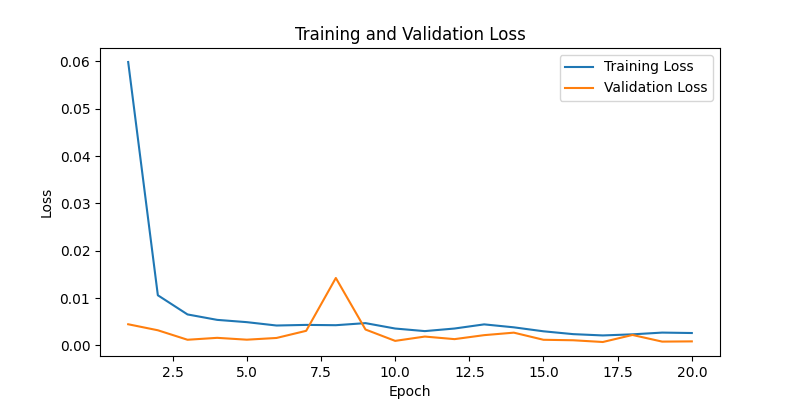

In [94]:
plot_prediction_vs_gt(scaler, predicted_x_axis, ground_truth_x_axis, start_date, end_date, train_data_len, train_validation_split)
plot_loss_chart(history)
